In [24]:
import io
from IPython.nbformat import current

def execute_notebook(nbfile):
    
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    
    ip = get_ipython()
    
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("../workers/Imports.ipynb")
execute_notebook("../workers/scoring_system.ipynb")

Populating the interactive namespace from numpy and matplotlib


6.6899999999999995

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Import data

In [3]:
# Import all individal shots
df = pd.read_csv('../../processed_data/identified_shots.csv', index_col=0)
df = df[df.player_id != '(null)']
df.player_id = df.player_id.astype(str)
len(df)

6727138

In [4]:
len(df.player_id.unique())

5649

In [5]:
# Import individual percentages (processed and selected by movement)
player_percentages = pd.read_csv('../../processed_data/players_percentages.18_22.csv', index_col=0)

In [6]:
# Import session info for learning
session_df = pd.read_csv('../../processed_data/session_df.18_22.movement_2.csv', index_col=0)

### Set variables

In [7]:
distance_min, distance_max = 18, 22

In [8]:
plotting_players = ['11105', '15801', '20071'] # Percentages: 50, 60, 69 (GREAT PCA)

In [9]:
player_percentages[player_percentages.Player.isin(plotting_players)]

,Number_of_shots,Percentage,Player
0,27636,0.503438,11105
1,25031,0.579481,15801
7,10524,0.746674,20071


### Distributions of shooter percentages

0
1
2


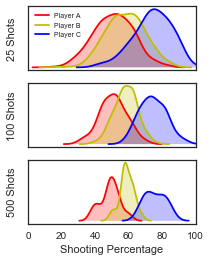

In [10]:
shot_counts = [25, 100, 500]
player_names = ['Player A', 'Player B', 'Player C']

sns.set_style("white")
f, axarr = plt.subplots(3, sharex=True, figsize=(3, 4))
minimum, maximum = 0, 100

colors = ['r', 'y', 'b']

for j, player in enumerate(plotting_players):
    print j
    player_df_by_date, player_average = get_player_df_by_date(player, distance_min, distance_max)
    
    for i, shot_count in enumerate(shot_counts):
        percentages = percentages_by_session(player_df_by_date, shot_count)*100
        if len(percentages) < 2:
            continue
        plt.subplot(len(shot_counts), 1, i+1)
        if i == 0:
            g = sns.kdeplot(percentages, shade=True, c=colors[j], label=player_names[j])
            plt.legend(prop={'size': 7})
        else:
            g = sns.kdeplot(percentages, shade=True, c=colors[j])
        g.set(yticklabels=[])
        plt.xlim(minimum, maximum)
        if g.is_last_row():
            plt.xlabel('Shooting Percentage')
        else:
            plt.xticks([])
        plt.ylabel(str(shot_count) + ' Shots')
plt.savefig('../../figures/distributions.pdf')

### T-SNE

In [11]:
def plot_unsupervised_clustering(session_df, f):

    lut = dict(zip(session_df.Player.unique(), "ryb"))
    row_colors = session_df.Player.map(lut)
    session_df['color'] = row_colors

    model = TSNE(n_components=2, random_state=0)
    pcs = model.fit_transform(np.array(session_df.ix[:, :9]))
    session_df['PC1'] = pcs[:, 0]
    session_df['PC2'] = pcs[:, 1]

    sns.set_style("white")
    plt.figure(figsize=(4, 4))
    player_labels = ['Player A', 'Player B', 'Player C']
    
    for i, color in enumerate(session_df.color.unique()):
        tmp_df = session_df[session_df.color == color]
        plt.scatter(tmp_df.PC1, tmp_df.PC2, color=tmp_df.color, alpha=0.8, s=4,
               label=player_labels[i])
    
    #plt.scatter(session_df.PC1, session_df.PC2, color=session_df.color, alpha=0.8, s=3,
    #           label=['Player A', 'Player B', 'Player C'])
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend(loc=4, prop={'size': 8})

    
    plt.savefig(f)
    plt.show()

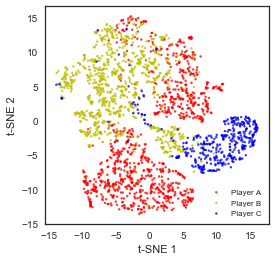

In [12]:
unsupervized_df = get_session_df(plotting_players, 25)
plot_unsupervised_clustering(unsupervized_df, '../../figures/TSNE.pdf')

### Learning

In [13]:
session_df.head()

,Angle_Avg,Angle_Cons,Angle_depth,Angle_left_Right,Depth_Avg,Depth_Cons,Depth_left_right,Left_Right_Avg,Left_Right_Cons,player_id,practice_percentage,sample_percentage
0,52.305103,2.681188,0.003278,0.846575,9.493193,6.267725,0.310063,-0.543612,4.929463,11105,0.503438,0.48
1,51.776051,2.536968,0.000878,0.292381,8.979122,4.758475,0.032260,-2.694590,4.737425,11105,0.503438,0.48
2,51.839923,2.076558,0.081975,0.280388,6.896520,5.304062,0.967980,-1.196093,4.748711,11105,0.503438,0.40
3,51.111430,1.938841,0.832293,0.136643,9.060859,5.789895,0.613540,-0.958324,5.180121,11105,0.503438,0.28
4,50.916738,2.368576,0.066233,0.572771,5.781677,5.887722,0.739520,-2.318109,4.530171,11105,0.503438,0.24


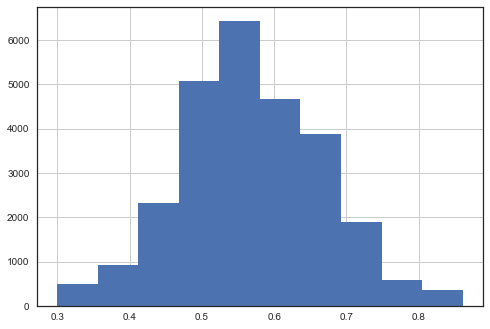

In [14]:
session_df.practice_percentage.hist()

0.3 0.4 1048
0.4 0.5 4672
0.5 0.6 11455
0.6 0.7 6741
0.7 0.8 2287


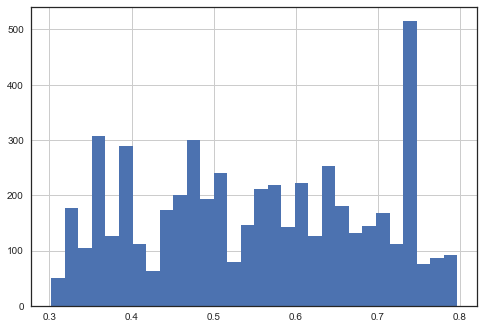

In [15]:
sample = 1048
all_dfs = []
for low, high in zip([0.3, 0.4, 0.5, 0.6, 0.7], [0.4, 0.5, 0.6, 0.7, 0.8]):
#for low, high in zip([0.4, 0.5, 0.6, 0.7], [0.5, 0.6, 0.7, 0.8]):
    print low, high, len(session_df[(session_df.practice_percentage > low)&(session_df.practice_percentage < high)])
    all_dfs.append(session_df[(session_df.practice_percentage > low)&(session_df.practice_percentage < high)].sample(sample))
session_df_balanced = pd.concat(all_dfs)

session_df_balanced.practice_percentage.hist(bins=30)

In [16]:
two_thirds = 2*len(list(session_df_balanced.player_id.unique()))/float(3)
training_players = list(session_df_balanced.player_id.sample(int(two_thirds)))
testing_players = [x for x in list(session_df_balanced.player_id.unique()) if x not in training_players]

shooter factors 0.00737686482846 (0.64105003408739181, 5.9616330698628115e-201)
sample percentage 0.0139858258217 (0.66370040885706727, 2.7230402662943114e-220)
both 0.00667898324811 (0.69304999739237549, 4.9767742755143171e-248)
[ 0.13  0.13  0.15  0.23  0.12  0.23  0.    0.    0.01]
[ 0.16  0.18  0.04  0.08  0.05  0.15  0.03  0.    0.04  0.27]


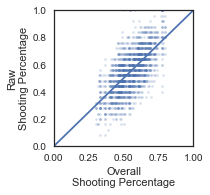

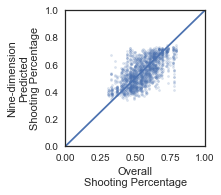

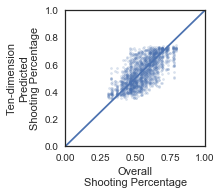

In [17]:
number_of_features = 9 # in addition to shooting percentage

X_train = np.matrix(session_df_balanced[session_df_balanced.player_id.isin(training_players)][['Angle_Avg', 'Angle_Cons', 'Depth_Avg', 'Depth_Cons', 'Left_Right_Avg', 'Left_Right_Cons', 'Depth_left_right', 'Angle_left_Right', 'Angle_depth', 'sample_percentage']])
X_test = np.matrix(session_df_balanced[session_df_balanced.player_id.isin(testing_players)][['Angle_Avg', 'Angle_Cons', 'Depth_Avg', 'Depth_Cons', 'Left_Right_Avg', 'Left_Right_Cons', 'Depth_left_right', 'Angle_left_Right', 'Angle_depth', 'sample_percentage']])
y_train = np.array(session_df_balanced[session_df_balanced.player_id.isin(training_players)].practice_percentage)
y_test = np.array(session_df_balanced[session_df_balanced.player_id.isin(testing_players)].practice_percentage)


# Train model with only shooter factors
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
        max_depth=1, random_state=0, loss='ls').fit(X_train[:, :number_of_features], y_train)
predictions1 = list(est.predict(X_test[:, :number_of_features]))
print 'shooter factors', mean_squared_error(y_test, predictions1), sp.pearsonr(y_test, predictions1)
print 'sample percentage', mean_squared_error(y_test, [x[0, 0] for x in X_test[:, number_of_features]]), sp.pearsonr(y_test, [x[0, 0] for x in X_test[:, number_of_features]])
# Train model with shooter factors and shooting percentage
est2 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
        max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)
predictions2 = list(est2.predict(X_test))
print 'both', mean_squared_error(y_test, predictions2), sp.pearsonr(y_test, predictions2)

# Which features are important?
print est.feature_importances_
print est2.feature_importances_

sns.set_style("white")

plt.figure(figsize=(2.5, 2.5))
plt.scatter(y_test, [X_test[i, number_of_features] for i in range(len(X_test))], alpha=0.2, s=5)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.plot([0,1])
plt.xlabel('Overall\nShooting Percentage')
plt.ylabel('Raw\nShooting Percentage')
plt.savefig('../../figures/model.scatter.shooting_percentage.pdf')
plt.show()
plt.clf()

plt.figure(figsize=(2.5, 2.5))
plt.scatter(y_test, predictions1, alpha=0.2, s=5)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.plot([0,1])
plt.xlabel('Overall\nShooting Percentage')
plt.ylabel('Nine-dimension\nPredicted\nShooting Percentage')
plt.savefig('../../figures/model.scatter.shooter_factors.pdf')
plt.show()
plt.clf()

plt.figure(figsize=(2.5, 2.5))
plt.scatter(y_test, predictions2, alpha=0.2, s=5)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.plot([0,1])
plt.xlabel('Overall\nShooting Percentage')
plt.ylabel('Ten-dimension\nPredicted\nShooting Percentage')
plt.savefig('../../figures/model.scatter.shooter_factors_and_shooting_percentage.pdf')
plt.show()
plt.clf()

pickle.dump(est, open('../../models/shooter_factors.p', 'w'))
pickle.dump(est2, open('../../models/shooter_factors_and_percentage.p', 'w'))

### Evaluation

In [18]:
prediction_results = pd.DataFrame({'Category': ['Raw\nShooting\nPercentage', 'Shooter\nFactors', 'Ten-dimension\nPredicted\nShooting Percentage'],
                                   'R': [sp.spearmanr(y_test, [x[0, 0] for x in X_test[:, number_of_features]])[0],
                                                    sp.spearmanr(y_test, predictions1)[0],
                                                   sp.spearmanr(y_test, predictions2)[0]],
                                    'MSE': [mean_squared_error(y_test, [x[0, 0] for x in X_test[:, number_of_features]]),
                                                mean_squared_error(y_test, predictions1),
                                                    mean_squared_error(y_test, predictions2)]})

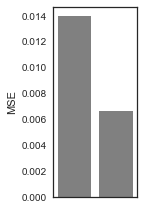

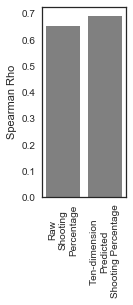

In [19]:
sns.set_style("white")

plt.figure(figsize=(1.5, 3.5))
sns.barplot(x='Category', y='MSE', data=prediction_results, order=['Raw\nShooting\nPercentage', 'Ten-dimension\nPredicted\nShooting Percentage'], color='grey')
plt.ylabel('MSE')
plt.xlabel('')
plt.xticks([])
plt.savefig('../../figures/model.MSE.pdf')
plt.show()
plt.clf()

plt.figure(figsize=(1.5, 3.5))
sns.barplot(x='Category', y='R', data=prediction_results, order=['Raw\nShooting\nPercentage', 'Ten-dimension\nPredicted\nShooting Percentage'], color='grey')
plt.ylabel('Spearman Rho')
plt.xlabel('')
plt.xticks(rotation=90)
plt.savefig('../../figures/model.R_squared.pdf')
plt.show()
plt.clf()

### Player comparison visualization

In [25]:
shot_counts = [25]

all_percentages, all_predictions, all_players = [], [], []
for j, player in enumerate(plotting_players):
    print j
    player_df_by_date, player_average = get_player_df_by_date(player, distance_min, distance_max)
    
    for i, shot_count in enumerate(shot_counts):
        percentages = percentages_by_session(player_df_by_date, shot_count)*100
        predictions = predictions_by_session(player_df_by_date, shot_count, est2)*100
        all_percentages.extend(percentages)
        all_predictions.extend(predictions)
        all_players.extend([player for x in percentages])

# as heatmap
comparison_df = pd.DataFrame({'Player': all_players,
                             'Percentages': all_percentages,
                             'Predictions': all_predictions})

unique_players = list(comparison_df.Player.unique())

def converter(x):
    if x == unique_players[0]:
        return 0 
    elif x == unique_players[1]:
        return 1.3
    else:
        return 2
comparison_df['player_color'] = comparison_df['Player'].apply(converter)

0
1
2


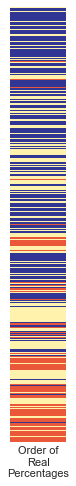

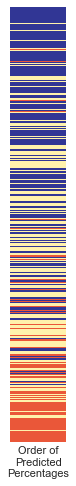

In [26]:
plt.figure(figsize=(1, 8))
sns.heatmap(comparison_df.sort_values('Percentages')[['player_color']], cmap="RdYlBu_r", 
            xticklabels=False, yticklabels=False, cbar=False, vmax=2.4, vmin=0)
plt.xlabel('Order of\nReal\nPercentages')
plt.savefig('../../figures/order.percentages.pdf')
plt.show()
plt.clf()

plt.figure(figsize=(1, 8))
sns.heatmap(comparison_df.sort_values('Predictions')[['player_color']], cmap="RdYlBu_r", 
            xticklabels=False, yticklabels=False, cbar=False, vmax=2.4, vmin=0)
plt.xlabel('Order of\nPredicted\nPercentages')
plt.savefig('../../figures/order.predictions.pdf')
plt.show()